<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 1</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

In [257]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import seaborn as sns
import os

np.random.seed(42)
random_state = 42

# --- load S2_A1_E1 ---
data_folder_name = "Data"
subject_folder_name = "s2"
subject_data_name = "S2_A1_E1.mat"
subject_data_path = os.path.join(data_folder_name, subject_folder_name, subject_data_name)

data = loadmat(subject_data_path)

emg       = data["emg"]                    # (T, n_channels)
stimulus  = data["restimulus"].ravel()     # corrected labels, 1D
repetition = data["rerepetition"].ravel()  # repetition indices, 1D

print("EMG shape:", emg.shape)
print("Unique stimulus labels:", np.unique(stimulus))
print("Unique repetition labels:", np.unique(repetition))

# NinaPro DB1 EMG sampling freq
fs = 100  # Hz

EMG shape: (100686, 10)
Unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique repetition labels: [ 0  1  2  3  4  5  6  7  8  9 10]


## 1. Visualize & preprocess

In [258]:
def remove_outliers_sliding_mad(
    emg,
    window=25,            # 25 samples = 250 ms
    thresh=3.0,           # typical: 2.5–4 × MAD
    replace_window=20     # median replacement window
):
    """
    Literature-based robust EMG outlier suppression:
    1) Compute local median & MAD over sliding window
    2) Mark values > thresh * MAD from median as outliers
    3) Replace with local median (± replace_window//2 samples)

    Recommended for RMS-coded EMG (NinaPro DB1).
    """
    T, C = emg.shape
    emg_clean = emg.copy().astype(float)

    half = window // 2
    half_rep = replace_window // 2

    for ch in range(C):
        x = emg_clean[:, ch]

        # Precompute local median and MAD
        med = np.zeros(T)
        mad = np.zeros(T)
        for t in range(T):
            i0 = max(0, t - half)
            i1 = min(T, t + half + 1)
            segment = x[i0:i1]
            med[t] = np.median(segment)
            mad[t] = np.median(np.abs(segment - med[t])) + 1e-12

        # Outlier condition: |x - median| > thresh × 1.4826 × MAD
        # (1.4826 scales MAD to STD-equivalent for Gaussian noise)
        scaled_mad = 1.4826 * mad
        outliers = np.abs(x - med) > thresh * scaled_mad

        # Replace outliers with local median of clean neighborhood
        for t in np.where(outliers)[0]:
            i0 = max(0, t - half_rep)
            i1 = min(T, t + half_rep + 1)
            window_vals = x[i0:i1]
            window_clean = window_vals[~outliers[i0:i1]]
            if len(window_clean) > 0:
                x[t] = np.median(window_clean)
            else:
                x[t] = np.median(window_vals)

        emg_clean[:, ch] = x

    return emg_clean


def bandpass_emg(emg, fs, bp=(5, 45)):
    """4th order Butterworth band-pass for DB1 EMG (100 Hz RMS-coded)."""
    sos_bp = butter(N=4, Wn=bp, fs=fs, btype="bandpass", output="sos")
    emg_filt = sosfiltfilt(sos_bp, emg.T).T
    return emg_filt


def rectified_envelope(emg_filt, window_samples=25):
    """Full-wave rectification + moving average envelope."""
    emg_rect = np.abs(emg_filt)
    w = np.ones(window_samples) / window_samples
    emg_env = convolve1d(emg_rect, w, axis=0, mode="nearest")
    return emg_env


In [259]:
# 1) Band-pass filter first (remove drift + HF noise)
emg_filt = bandpass_emg(emg, fs)

# 2) Remove outliers using MAD-based sliding window (robust)
emg_clean = remove_outliers_sliding_mad(
    emg_filt,
    window=20,          # 250 ms
    thresh=3.0,         # conservative threshold
    replace_window=20   # ±10 samples (100 ms)
)

# 3) Rectify + smooth (envelope extraction)
emg_env = rectified_envelope(emg_clean, window_samples=25)


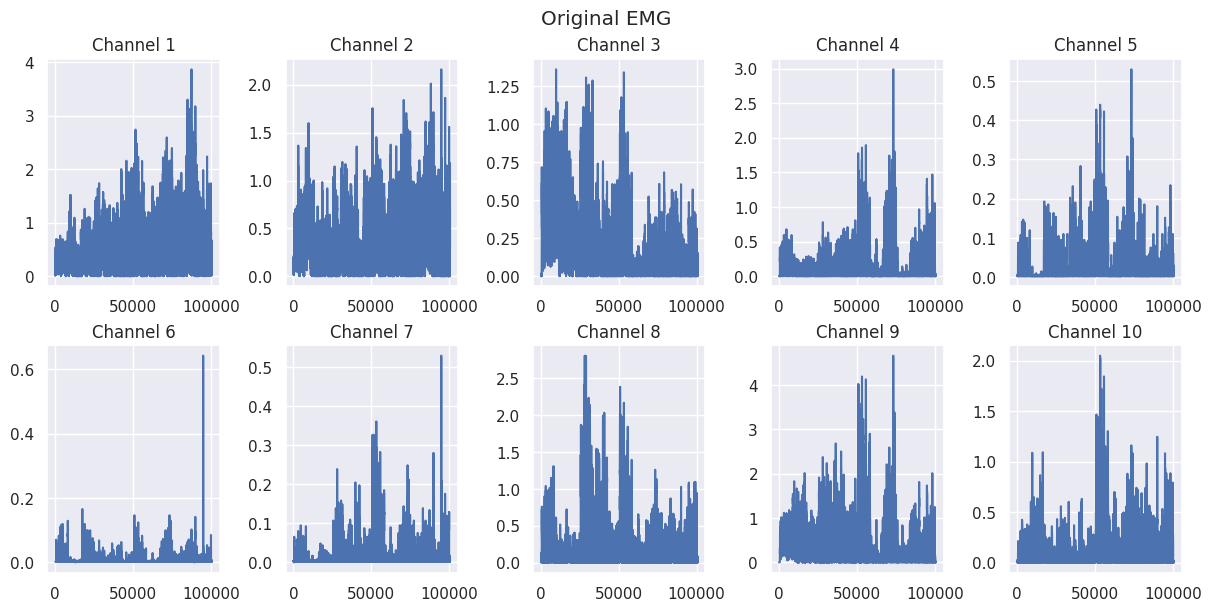

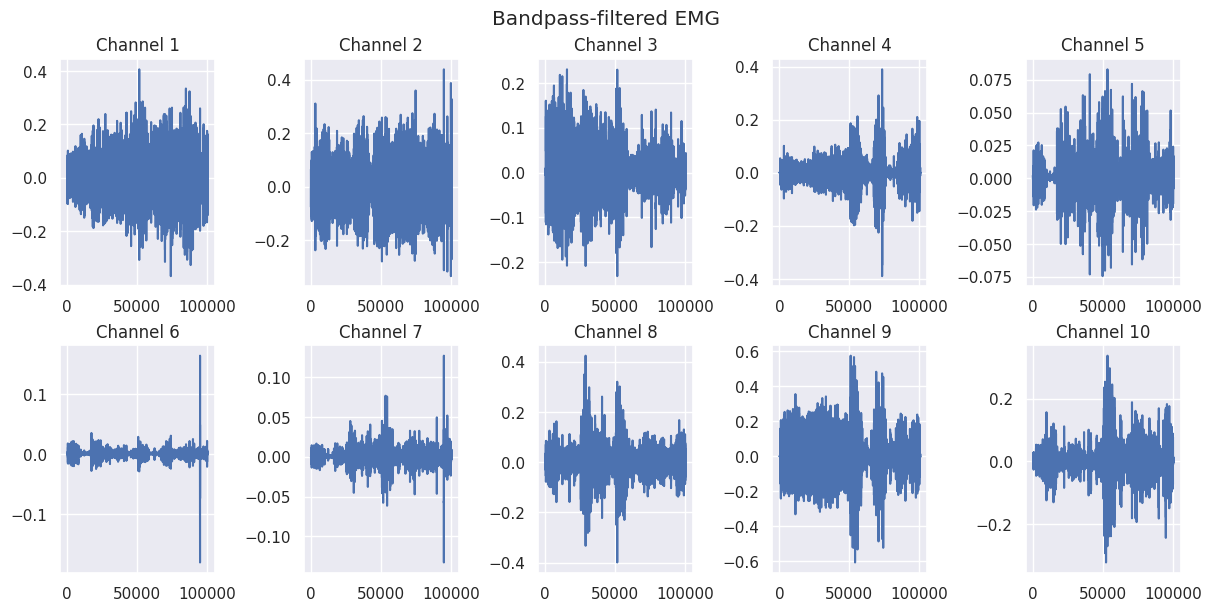

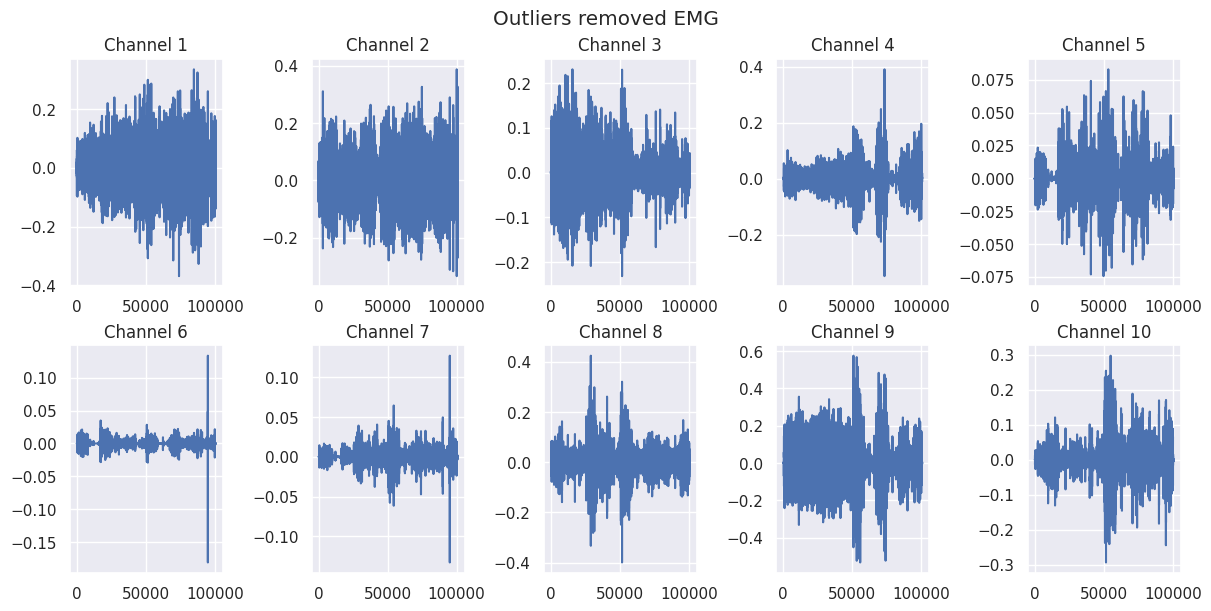

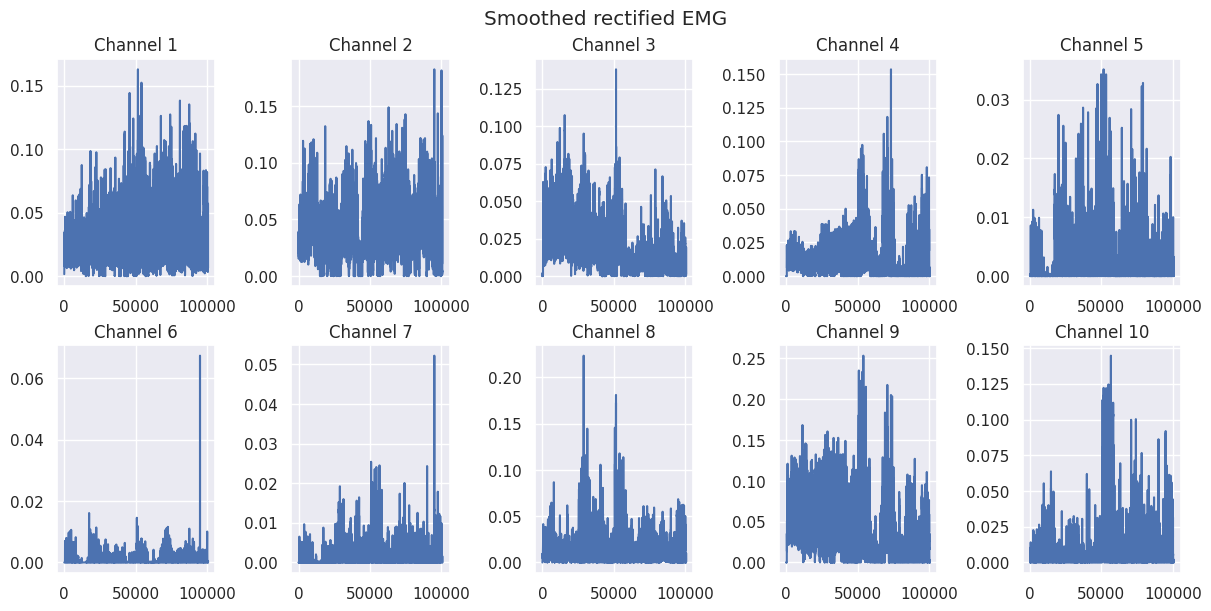

In [260]:
plt.close("all")

#10 EMG channels
number_of_emg_channels = emg.shape[-1]
signals = [emg, emg_filt, emg_clean, emg_env]
names = ["Original EMG", "Bandpass-filtered EMG", "Outliers removed EMG", "Smoothed rectified EMG"]

for i, _ in enumerate(signals):
    # plot Envelopes of the EMG signal
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
    ax = ax.ravel()
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(signals[i][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(names[i])

In [261]:
def get_epochs(emg_env, stimulus, repetition):
    """
    Build one epoch per (movement class, repetition) pair.
    Returns:
        epochs: list of arrays, each (T_i, n_channels)
        labels: 1D array, class label per epoch
    """
    classes = np.unique(stimulus)
    classes = classes[classes != 0]        # remove rest class
    reps = np.unique(repetition)
    reps = reps[reps != 0]                 # remove 0 (no repetition)

    epochs = []
    labels = []

    for c in classes:
        for r in reps:
            idx = np.logical_and(stimulus == c, repetition == r)
            if not np.any(idx):
                continue
            epoch = emg_env[idx, :]
            # optional: drop too-short epochs
            if epoch.shape[0] < 5:
                continue
            epochs.append(epoch)
            labels.append(int(c))

    return epochs, np.array(labels)

epochs, labels = get_epochs(emg_env, stimulus, repetition)
print("Number of epochs:", len(epochs))
print("Unique labels:", np.unique(labels))
print("Example epoch shape:", epochs[0].shape)


Number of epochs: 120
Unique labels: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Example epoch shape: (307, 10)


## 3. Feature extraction & visualization

In [262]:
# --- EMG feature functions (extended) ---

def mav(x):        # Mean Absolute Value
    return np.mean(np.abs(x), axis=0)

def rms(x):        # Root Mean Square
    return np.sqrt(np.mean(x**2, axis=0))

def var_feature(x):  # Variance (power)
    return np.var(x, axis=0)

def wl(x):         # Waveform Length
    return np.sum(np.abs(np.diff(x, axis=0)), axis=0)

def ssc(x, threshold=1e-6):  # Slope Sign Changes
    diff = np.diff(x, axis=0)
    sign = np.sign(diff)
    changes = np.diff(sign, axis=0)
    return np.sum(np.abs(changes) > 0, axis=0)

def maxav(x):      # Mean of top 10% abs values
    n = x.shape[0]
    k = max(1, n // 10)
    abs_sorted = np.sort(np.abs(x), axis=0)[-k:, :]
    return np.mean(abs_sorted, axis=0)

def iemg(x):       # Integrated EMG
    return np.sum(np.abs(x), axis=0)

def zc(x, threshold=1e-6):   # Zero Crossings
    # count sign changes where amplitude change exceeds threshold
    x1 = x[:-1, :]
    x2 = x[1:, :]
    crossings = (x1 * x2) < 0
    amp_diff  = np.abs(x2 - x1) > threshold
    return np.sum(crossings & amp_diff, axis=0)

def mean_feature(x):  # Mean value
    return np.mean(x, axis=0)

def kurtosis_feature(x, eps=1e-12):  # Kurtosis per channel
    m = np.mean(x, axis=0)
    v = np.var(x, axis=0) + eps
    centered = x - m
    return np.mean(centered**4, axis=0) / (v**2 + eps)

# Keep a parallel list of names for interpretability
feature_fns = [
    mav,
    rms,
    var_feature,
    wl,
    # ssc,
    # maxav,
    # iemg,
    # zc,
    # mean_feature,
    # kurtosis_feature,
]

feature_names = [
    "MAV",
    "RMS",
    "VAR",
    "WL",
    "SSC",
    "MAXAV",
    "IEMG",
    "ZC",
    "MEAN",
    "KURTOSIS",
]


In [263]:
def build_dataset_from_ninapro(epochs, labels, features):
    """
    epochs: list of (T_i, n_channels) arrays
    labels: 1D array of length n_samples
    features: list of functions (T,n_ch) -> (n_ch,)
    Returns:
        X: (n_samples, n_channels * n_features_per_channel)
        y: (n_samples,)
    """
    n_samples = len(epochs)
    n_channels = epochs[0].shape[1]
    n_feat_per_ch = len(features)

    X = np.zeros((n_samples, n_channels * n_feat_per_ch))

    for i, epoch in enumerate(epochs):
        feat_list = [f(epoch) for f in features]      # each (n_channels,)
        feats = np.stack(feat_list, axis=0).reshape(-1)
        X[i, :] = feats

    y = labels.copy()
    return X, y

X, y = build_dataset_from_ninapro(epochs, labels, feature_fns)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (120, 40)
y shape: (120,)


## 4. Gradient boosting classification

In [264]:
from sklearn.model_selection import train_test_split

# 60 % train
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
# 20% val 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z   = scaler.transform(X_val)
X_test_z  = scaler.transform(X_test)

print("Train size:", X_train_z.shape[0])
print("Val size:", X_val_z.shape[0])
print("Test size:", X_test_z.shape[0])


Train size: 72
Val size: 24
Test size: 24


In [265]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_z, y_train)

y_val_pred = gb.predict(X_val_z)
print("Baseline val accuracy:", accuracy_score(y_val, y_val_pred))
print("Baseline val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))


Baseline val accuracy: 0.5833333333333334
Baseline val macro-F1: 0.561111111111111


### Hyperparameter optimization

In [266]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3],
    "subsample": [0.7, 1.0],
    "max_features": ["sqrt", None],
}

gb_base = GradientBoostingClassifier(random_state=42)

grid = GridSearchCV(
    gb_base,
    param_grid,
    scoring="f1_macro",  # previously "accuracy"
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_z, y_train)

print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

best_gb = grid.best_estimator_


Best params: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.7}
Best CV macro-F1: 0.7672222222222221


## 5. Performance metric & interpretation

Val accuracy: 0.75
Val macro-F1: 0.7527777777777778
Test accuracy: 0.875
Test macro-F1: 0.8444444444444444


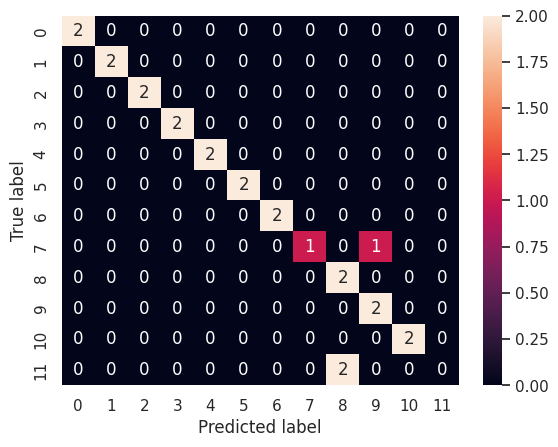

In [267]:
y_val_pred = best_gb.predict(X_val_z)
print("Val accuracy:", accuracy_score(y_val, y_val_pred))
print("Val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))

y_test_pred = best_gb.predict(X_test_z)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test macro-F1:", f1_score(y_test, y_test_pred, average="macro"))

cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");


## 6. Feature selection / dimension reduction

In [274]:
mi = mutual_info_classif(X_train_z, y_train, random_state=42)
k = min(20, X_train_z.shape[1])  # top 20 or fewer if dim<20

selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train_z, y_train)

X_train_fs = selector.transform(X_train_z)
X_val_fs   = selector.transform(X_val_z)
X_test_fs  = selector.transform(X_test_z)

gb_fs = GradientBoostingClassifier(random_state=42, **grid.best_params_)
gb_fs.fit(X_train_fs, y_train)

y_test_pred_fs = gb_fs.predict(X_test_fs)
print("FS Test accuracy:", accuracy_score(y_test, y_test_pred_fs))
print("FS Test macro-F1:", f1_score(y_test, y_test_pred_fs, average="macro"))


FS Test accuracy: 0.7083333333333334
FS Test macro-F1: 0.65


In [275]:
pca = PCA(n_components=0.95, svd_solver="full")  # keep 95% variance
pca.fit(X_train_z)

X_train_pca = pca.transform(X_train_z)
X_val_pca   = pca.transform(X_val_z)
X_test_pca  = pca.transform(X_test_z)

gb_pca = GradientBoostingClassifier(random_state=42, **grid.best_params_)
gb_pca.fit(X_train_pca, y_train)

y_test_pred_pca = gb_pca.predict(X_test_pca)
print("PCA Test accuracy:", accuracy_score(y_test, y_test_pred_pca))
print("PCA Test macro-F1:", f1_score(y_test, y_test_pred_pca, average="macro"))
print("Number of PCA components:", X_train_pca.shape[1])


PCA Test accuracy: 0.7083333333333334
PCA Test macro-F1: 0.7138888888888889
Number of PCA components: 18


### Permutation features importance

In [ ]:
feature_fns = [mav, rms, var_feature, wl, ssc, maxav, iemg, zc, mean_feature, kurtosis_feature]
X, y = build_dataset_from_ninapro(epochs, labels, feature_fns)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z   = scaler.transform(X_val)
X_test_z  = scaler.transform(X_test)
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_z, y_train)
y_val_pred = gb.predict(X_val_z)
print("Baseline val accuracy:", accuracy_score(y_val, y_val_pred))
print("Baseline val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))



Baseline val accuracy: 0.6666666666666666
Baseline val macro-F1: 0.6531746031746032


In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on the test set
result = permutation_importance(
    gb,
    X_test_z,
    y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring="f1_macro",  # match your main metric
)

importances_mean = result.importances_mean      # shape: (n_features,)
importances_std  = result.importances_std


In [ ]:
n_channels = epochs[0].shape[1]
n_feat_per_ch = len(feature_fns)

assert importances_mean.shape[0] == n_channels * n_feat_per_ch

imp_matrix = importances_mean.reshape(n_feat_per_ch, n_channels)  # (features, channels)

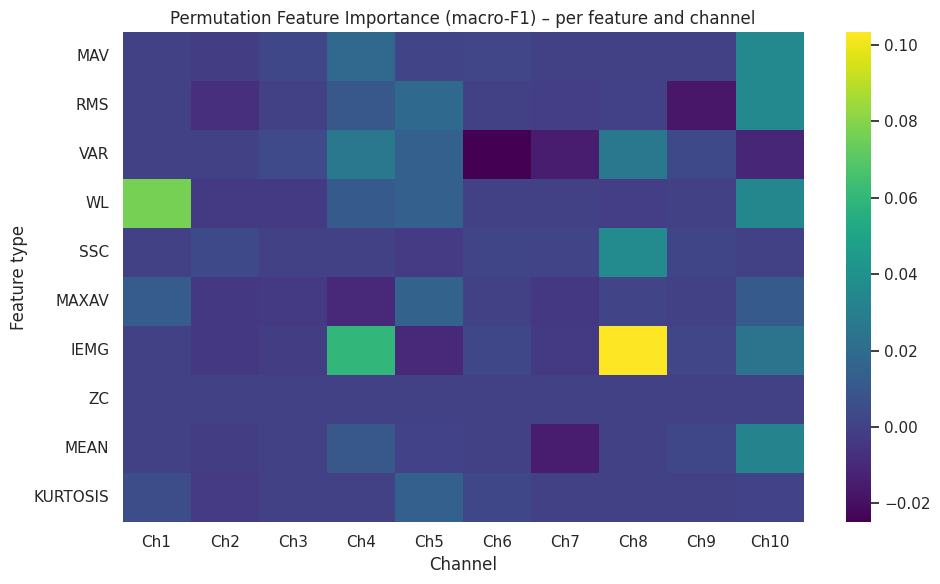

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    imp_matrix,
    annot=False,
    cmap="viridis",
    xticklabels=[f"Ch{c+1}" for c in range(n_channels)],
    yticklabels=feature_names,
)
plt.xlabel("Channel")
plt.ylabel("Feature type")
plt.title("Permutation Feature Importance (macro-F1) – per feature and channel")
plt.tight_layout()
plt.show()


In [ ]:
feat_importance = imp_matrix.mean(axis=1)  # average over channels

feat_ranking = sorted(
    zip(feature_names, feat_importance),
    key=lambda x: x[1],
    reverse=True,
)

print("Average permutation importance per feature type:")
for name, score in feat_ranking:
    print(f"{name:10s}: {score:.4f}")


Average permutation importance per feature type:
IEMG      : 0.0171
WL        : 0.0126
MAV       : 0.0056
SSC       : 0.0040
RMS       : 0.0036
MEAN      : 0.0027
VAR       : 0.0023
KURTOSIS  : 0.0019
MAXAV     : 0.0017
ZC        : 0.0000


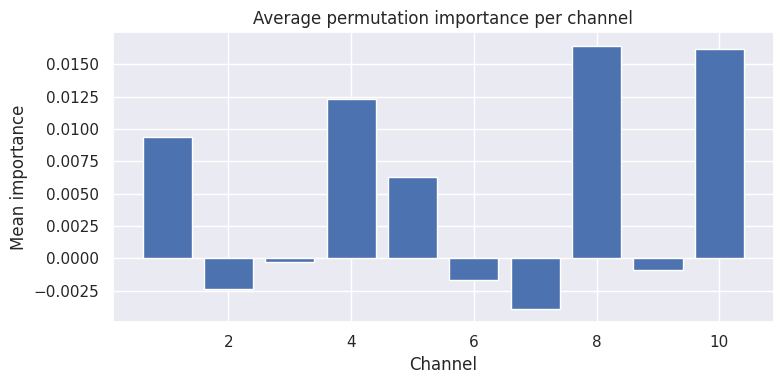

In [ ]:
channel_importance = imp_matrix.mean(axis=0)  # average over features

plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, n_channels+1), channel_importance)
plt.xlabel("Channel")
plt.ylabel("Mean importance")
plt.title("Average permutation importance per channel")
plt.tight_layout()
plt.show()
